In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline

# Overview

In [91]:
movies_df = pd.read_csv("moviesData.csv")
movies_df.rename(columns = {"Titles":"Title"}, inplace=True)
movies_df["IMDb"] *= 10  # scaling to match other ratings
movies_df.head()

19


,Title,Rating,RTCritic,RTFan,IMDb,Metacritic,BoxOffice,Year,Action,Animation,Family,Scifi,Comedy,Drama,International,Romance,Horror,Mystery,Documentary
0,Treasure Planet,PG,69,70,71.0,60,38120554,2002,1,1,1,1,0,0,0,0,0,0,0
1,About Schmidt,R,85,74,72.0,85,65005217,2002,0,0,0,0,1,1,0,0,0,0,0
2,Secretary,R,76,82,70.0,63,4046737,2002,0,0,0,0,1,1,1,1,0,0,0
3,Irreversible,NR,57,80,74.0,51,792200,2002,0,0,0,0,0,1,1,0,0,0,0
4,Big Trouble,PG13,48,54,65.0,47,7262288,2002,0,0,0,0,1,1,0,0,0,0,0


# Genre breakdown

In [66]:
genre_ratings = []
genre_titles = list(movies_df)[10:19]
for genre_title in genre_titles:
    genre_ratings.extend( [
        genre_title,
        len(movies_df[movies_df[genre_title]==1]),
        movies_df[movies_df[genre_title]==1]["allFans"].mean(),
        movies_df[movies_df[genre_title]==1]["allCritics"].mean()
        ])
print(genre_ratings)
genre_df = pd.DataFrame(np.array(genre_ratings).reshape(9,4), columns = ["genre","count", "allFans", "allCritics"])
genre_df.head()

['Family', 13, 62.76923076923077, 57.76923076923077, 'Scifi', 56, 57.3125, 35.669642857142854, 'Comedy', 28, 63.05357142857143, 57.5, 'Drama', 38, 66.89473684210526, 60.71052631578947, 'International', 1, 66.0, 64.0, 'Romance', 37, 55.270270270270274, 26.16216216216216, 'Horror', 10, 50.5, 40.05, 'Mystery', 25, 59.82, 52.9, 'Documentary', 1, 69.5, 57.5]


,genre,count,allFans,allCritics
0,Family,13,62.76923076923077,57.76923076923077
1,Scifi,56,57.3125,35.669642857142854
2,Comedy,28,63.05357142857143,57.5
3,Drama,38,66.89473684210526,60.71052631578947
4,International,1,66.0,64.0


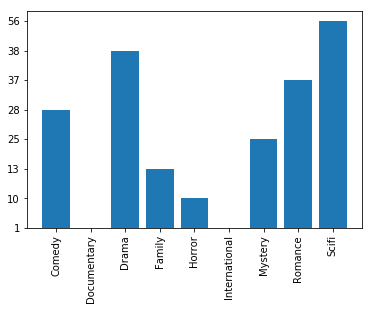

In [67]:
x = genre_df["genre"]
y = genre_df["count"]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

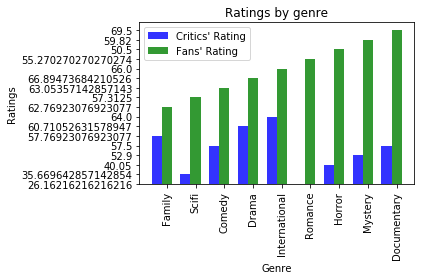

In [82]:
n_groups = 9

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, genre_df["allCritics"], bar_width,
                 alpha=opacity,
                 color='b',
                 label="Critics' Rating")
 
rects2 = plt.bar(index + bar_width, genre_df["allFans"], bar_width,
                 alpha=opacity,
                 color='g',
                 label="Fans' Rating")
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.title('Ratings by genre')
#plt.yticks(np.arange(80))  - why doesn't this work?
plt.xticks(index + bar_width, genre_df["genre"], rotation=90)
plt.legend()
 
plt.tight_layout()
plt.show()

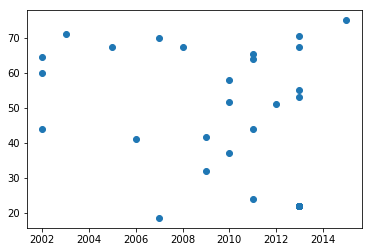

In [88]:
movies_df[movies_df["Scifi"]==1].head()

x = movies_df[movies_df["Scifi"]==1]["Year"]
y = movies_df[movies_df["Scifi"]==1]["allCritics"]
plt.scatter(x,y)
plt.show()

In [64]:
ax = sns.barplot(x="Genre", y="allCritics", hue="bechdel", data=movies_df)
plt.show()

TypeError: cannot label index with a null key

# Merging

In [93]:
# combine the two fan ratings columns into one composite fan rating column
movies_df["allFans"] = (movies_df["IMDb"] + movies_df["RTFan"])/2
# combine the two critic ratings columns into one composit critic rating column
movies_df["allCritics"] = (movies_df["RTCritic"] + movies_df["Metacritic"])/2

# import and merge additional movie data for these movies
movies_basic_metadata_df = pd.read_csv("movies_basic_metadata.csv")
bechdel_df = pd.read_csv("bechdel_basic.csv")
print("initial movies_df row count: {}".format(len(movies_df.columns)))
print("movies_basic_metadata row count: {}".format(len(movies_basic_metadata_df.columns)))
print("bechdel row count: {}".format(len(bechdel_df.columns)))

movies_df = movies_df.merge(movies_basic_metadata_df.drop_duplicates("title"), how="inner", left_on="Title", right_on="title")
movies_df = movies_df1.merge(bechdel_df, how="inner", left_on="Title", right_on="title")

print("new (total) movies_df row count: {}".format(len(movies_df.columns)))
movies_df.head()


initial movies_df row count: 21
movies_basic_metadata row count: 11
bechdel row count: 4
new (total) movies_df row count: 98


,Title,Rating,RTCritic,RTFan,IMDb,Metacritic,BoxOffice,Year,Action,Animation,...,revenue,runtime,status,tagline,vote_average,vote_count,title_y,bechdel_y,domgross,intgross
0,Treasure Planet,PG,69,70,71.0,60,38120554,2002,1,1,...,109578115.0,95.0,Released,Find your place in the universe.,7.2,980.0,Treasure Planet,FAIL,38120554.0,91800000.0
1,About Schmidt,R,85,74,72.0,85,65005217,2002,0,0,...,105834556.0,125.0,Released,Schmidt Happens,6.7,365.0,About Schmidt,FAIL,65005217.0,105823486.0
2,Resident Evil,R,34,67,67.0,33,40119709,2002,1,0,...,102984862.0,100.0,Released,A secret experiment. A deadly virus. A fatal m...,6.4,2100.0,Resident Evil,PASS,40119709.0,103787401.0
3,Panic Room,R,76,63,68.0,65,95308367,2002,0,0,...,196397415.0,111.0,Released,NaN,6.6,1303.0,Panic Room,PASS,95308367.0,196308367.0
4,Die Another Day,PG13,58,41,61.0,58,160942139,2002,1,0,...,431971116.0,133.0,Released,He’s never been cooler.,5.8,1112.0,Die Another Day,FAIL,160942139.0,431942139.0


In [15]:
print(movies_df["RTCritic"].mean())
print(movies_df["RTFan"].mean())
print(movies_df["RTCritic"].std())
print(movies_df["RTFan"].std())
print(movies_df["Metacritic"].mean())
print(movies_df["Metacritic"].std())
print(movies_df["IMDb"].mean()*10)

51.47555555555556
59.14666666666667
26.562436181062456
18.47103910759451
52.8
16.80720508761474
64.10222222222222


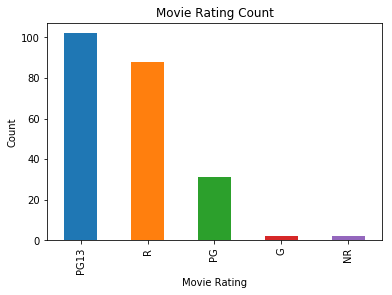

In [23]:
#count of category occurence in data
movies_df.Rating.value_counts().plot(kind = "bar")
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Movie Rating Count');

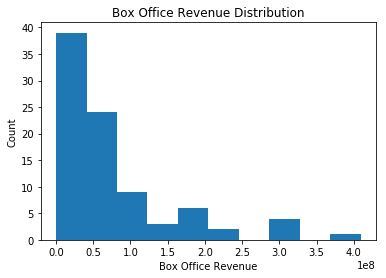

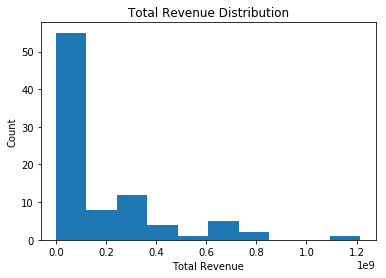

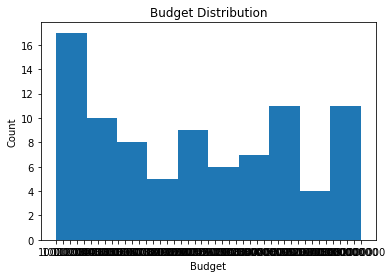

In [33]:
plt.hist(movies_df["BoxOffice"])
plt.xlabel('Box Office Revenue')
plt.ylabel('Count')
plt.title('Box Office Revenue Distribution')
plt.show()

plt.hist(movies_df["revenue_y"])
plt.xlabel('Total Revenue')
plt.ylabel('Count')
plt.title('Total Revenue Distribution')
plt.show()

plt.hist(movies_df["budget_y"])
plt.xlabel('Budget')
plt.ylabel('Count')
plt.title('Budget Distribution')
plt.show()

# Critical vs Popular Ratings

''

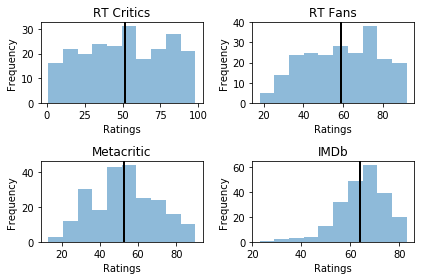

In [24]:
plt.subplot(2,2,1, )
plt.hist(movies_df['RTCritic'], label="RT Critic", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Critics')
plt.axvline(movies_df["RTCritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,2)
plt.hist(movies_df['RTFan'], label="RT Fan", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Fans')
plt.axvline(movies_df["RTFan"].mean(), color='black', linewidth=2)

plt.subplot(2,2,3)
plt.hist(movies_df['Metacritic'], label="Metacritic", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Metacritic')
plt.tight_layout()
plt.axvline(movies_df["Metacritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,4)
plt.hist(movies_df['IMDb'], label="IMDb", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('IMDb')
plt.tight_layout()
plt.axvline(movies_df["IMDb"].mean(), color='black', linewidth=2)
;

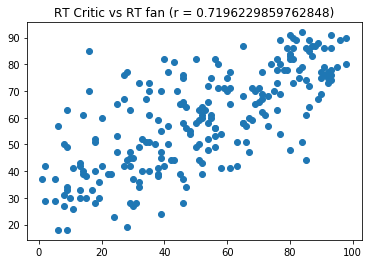

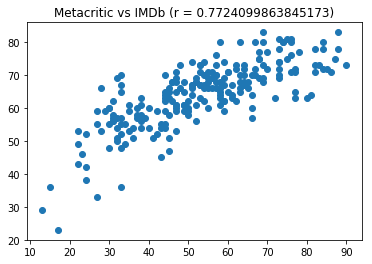

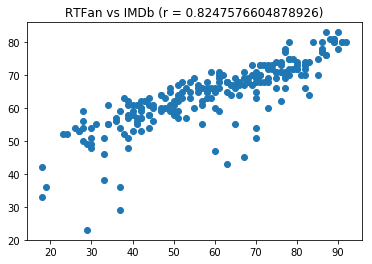

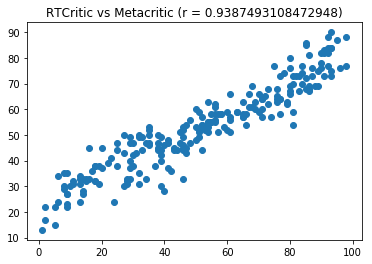

In [25]:
x = movies_df["RTCritic"]
y = movies_df["RTFan"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Critic vs RT fan (r = {})".format(r))
plt.show()

x = movies_df["Metacritic"]
y = movies_df["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Metacritic vs IMDb (r = {})".format(r))
plt.show()

x = movies_df["RTFan"]
y = movies_df["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RTFan vs IMDb (r = {})".format(r))
plt.show()

x = movies_df["RTCritic"]
y = movies_df["Metacritic"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RTCritic vs Metacritic (r = {})".format(r))
plt.show()


# Ratings as predictors of box office revenue

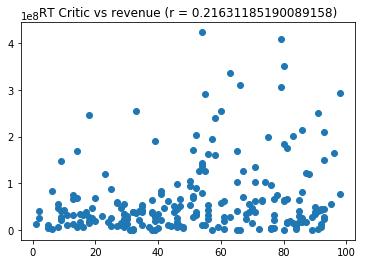

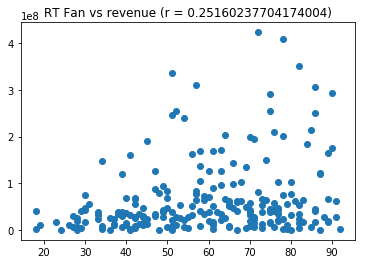

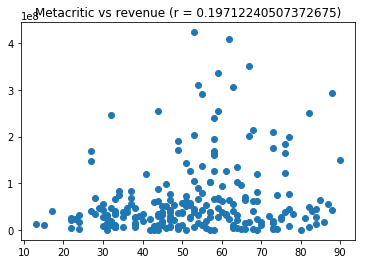

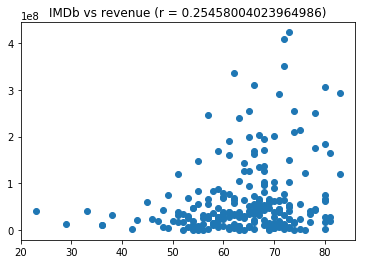

In [26]:
x = movies_df["RTCritic"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Critic vs revenue (r = {})".format(r))
plt.show()

x = movies_df["RTFan"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Fan vs revenue (r = {})".format(r))
plt.show()

x = movies_df["Metacritic"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Metacritic vs revenue (r = {})".format(r))
plt.show()

x = movies_df["IMDb"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("IMDb vs revenue (r = {})".format(r))
plt.show()


# Possible Factors in Critical-vs-Popular rating discrepancies

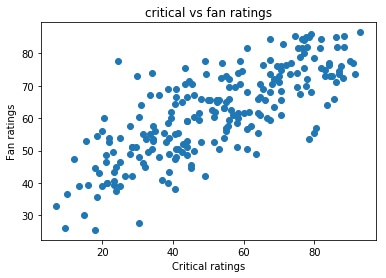

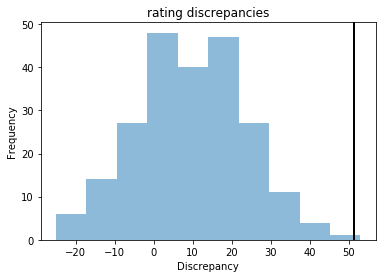

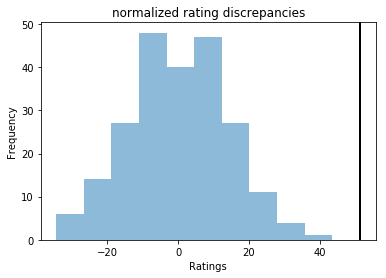

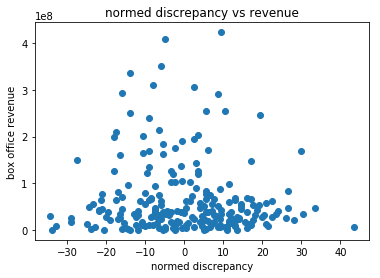

In [27]:
movies_df["allFans"] = (movies_df["IMDb"] + movies_df["RTFan"])/2
movies_df["allCritics"] = (movies_df["RTCritic"] + movies_df["Metacritic"])/2
movies_df["discrepancy"] = movies_df["allFans"] - movies_df["allCritics"]
movies_df["normDiscrepancy"] = (movies_df["allFans"]-movies_df["allFans"].mean()) \
                                - (movies_df["allCritics"]-movies_df["allCritics"].mean())

plt.scatter(movies_df['allCritics'], movies_df["allFans"])
plt.xlabel('Critical ratings')
plt.ylabel('Fan ratings')
plt.title("critical vs fan ratings")
plt.show()

plt.hist(movies_df['discrepancy'], alpha=0.5)
plt.xlabel('Discrepancy')
plt.ylabel('Frequency')
plt.title('rating discrepancies')
plt.axvline(movies_df["RTCritic"].mean(), color='black', linewidth=2)
plt.show()

plt.hist(movies_df['normDiscrepancy'], alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title("normalized rating discrepancies")
plt.axvline(movies_df["RTCritic"].mean(), color='black', linewidth=2)
plt.show()

plt.scatter(movies_df['normDiscrepancy'], movies_df["BoxOffice"])
plt.xlabel('normed discrepancy')
plt.ylabel('box office revenue')
plt.title("normed discrepancy vs revenue")
plt.show()


# Year effects
basically, there aren't any

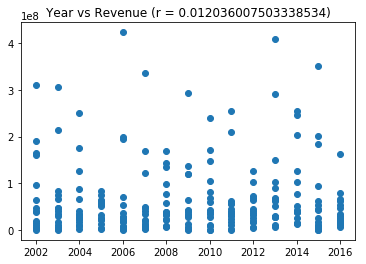

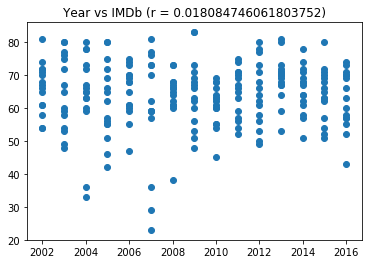

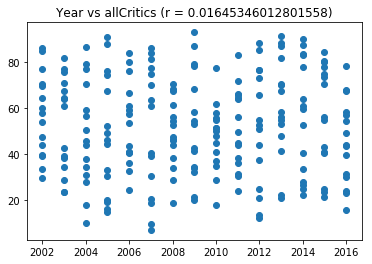

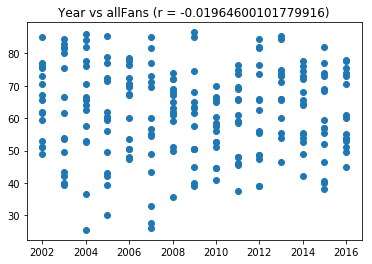

In [28]:
x = movies_df["Year"]
y = movies_df["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs Revenue (r = {})".format(r))
plt.show()

x = movies_df["Year"]
y = movies_df["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs IMDb (r = {})".format(r))
plt.show()

x = movies_df["Year"]
y = movies_df["allCritics"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs allCritics (r = {})".format(r))
plt.show()

x = movies_df["Year"]
y = movies_df["allFans"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Year vs allFans (r = {})".format(r))
plt.show()


In [ ]:
g = sns.FacetGrid(movies_df, col="Rating",  row="BoxOffice")
g = g.map(plt.scatter, "allFans", "allCritics")
plt.show()